In [5]:
from risk_experiment.utils import Subject, get_all_subjects
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
subjects = get_all_subjects('/data/ds-risk')

In [7]:
from tqdm.notebook import tqdm

In [8]:
pars = []
keys = []

for sub in tqdm(subjects):

    for session in ['3t1', '3t2', '7t1', '7t2']:
        try:
            if session.endswith('2'):
                pars.append(sub.get_prf_parameters_volume(session, None, cross_validated=False, smoothed=True, denoise=True, retroicor=False, roi='npcr', include_r2=True, include_cvr2=True, epi_space=False))
            else:
                pars.append(sub.get_prf_parameters_volume(session, None, cross_validated=False, smoothed=True, denoise=False, retroicor=False, roi='npcr', include_r2=True, include_cvr2=False, epi_space=False))

            keys.append((sub.subject, session))

        except Exception as e:
            print(f'Problem with {sub.subject}/{session}: {e}')

  0%|          | 0/30 [00:00<?, ?it/s]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 09/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-09/ses-7t2/func/sub-09_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 10/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-10/ses-7t2/func/sub-10_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 16/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.denoise.smoothed.natural_space/sub-16/ses-7t2/func/sub-16_ses-7t2_desc-mu.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 17/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-17/ses-7t2/func/sub-17_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 18/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.denoise.smoothed.natural_space/sub-18/ses-7t2/func/sub-18_ses-7t2_desc-mu.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 20/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-20/ses-7t2/func/sub-20_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 21/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-21/ses-7t2/func/sub-21_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 23/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.denoise.smoothed.natural_space/sub-23/ses-7t2/func/sub-23_ses-7t2_desc-mu.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 25/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-25/ses-7t2/func/sub-25_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 26/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-26/ses-7t2/func/sub-26_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 27/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-27/ses-7t2/func/sub-27_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 28/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-28/ses-7t2/func/sub-28_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 31/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-31/ses-7t2/func/sub-31_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data[:, :, :, 0], affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/_utils/niimg_conversions.py:292: UserWarning: Data array u

Problem with 32/7t2: File not found: '/data/ds-risk/derivatives/encoding_model.cv.denoise.smoothed.natural_space/sub-32/ses-7t2/func/sub-32_ses-7t2_desc-cvr2.optim_space-T1w_pars.nii.gz'


In [ ]:
pars = pd.concat(pars, keys=keys, names=['subject', 'session'])

In [ ]:
pars = pars.unstack('session')

In [ ]:
m = (pars[('cvr2', '7t2')] > 0.0) & (pars[('cvr2', '3t2')] > 0.0)

In [ ]:
p1 = pars.groupby('subject').apply(lambda d: d['r2'].corr()).stack().to_frame('r')
p2 = pars[m].groupby('subject').apply(lambda d: d['r2'].corr()).stack().to_frame('r')
p3 = pars.groupby('subject').apply(lambda d: d['mu'].corr()).stack().to_frame('r')
p4 = pars[m].groupby('subject').apply(lambda d: d['mu'].corr()).stack().to_frame('r')

r = pd.concat((p1, p2, p3, p4), keys=[('r2', 'all voxels'), ('r2', 'cross-validated R2 > 0.0 for 3t2 and 7t2'), ('mu', 'all voxels'), ('mu', 'cross-validated R2 > 0.0 for 3t2 and 7t2')], names=['parameter', 'type'])

r = r[r.index.get_level_values(-2) != r.index.get_level_values(-1)]

r.index.set_names(['session 1', 'session 2'], [-2, -1], inplace=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_58515/1631213453.py:10: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_names except for the argument 'names' will be keyword-only.
  r.index.set_names(['session 1', 'session 2'], [-2, -1], inplace=True)


In [ ]:
sns.set_context('talk')

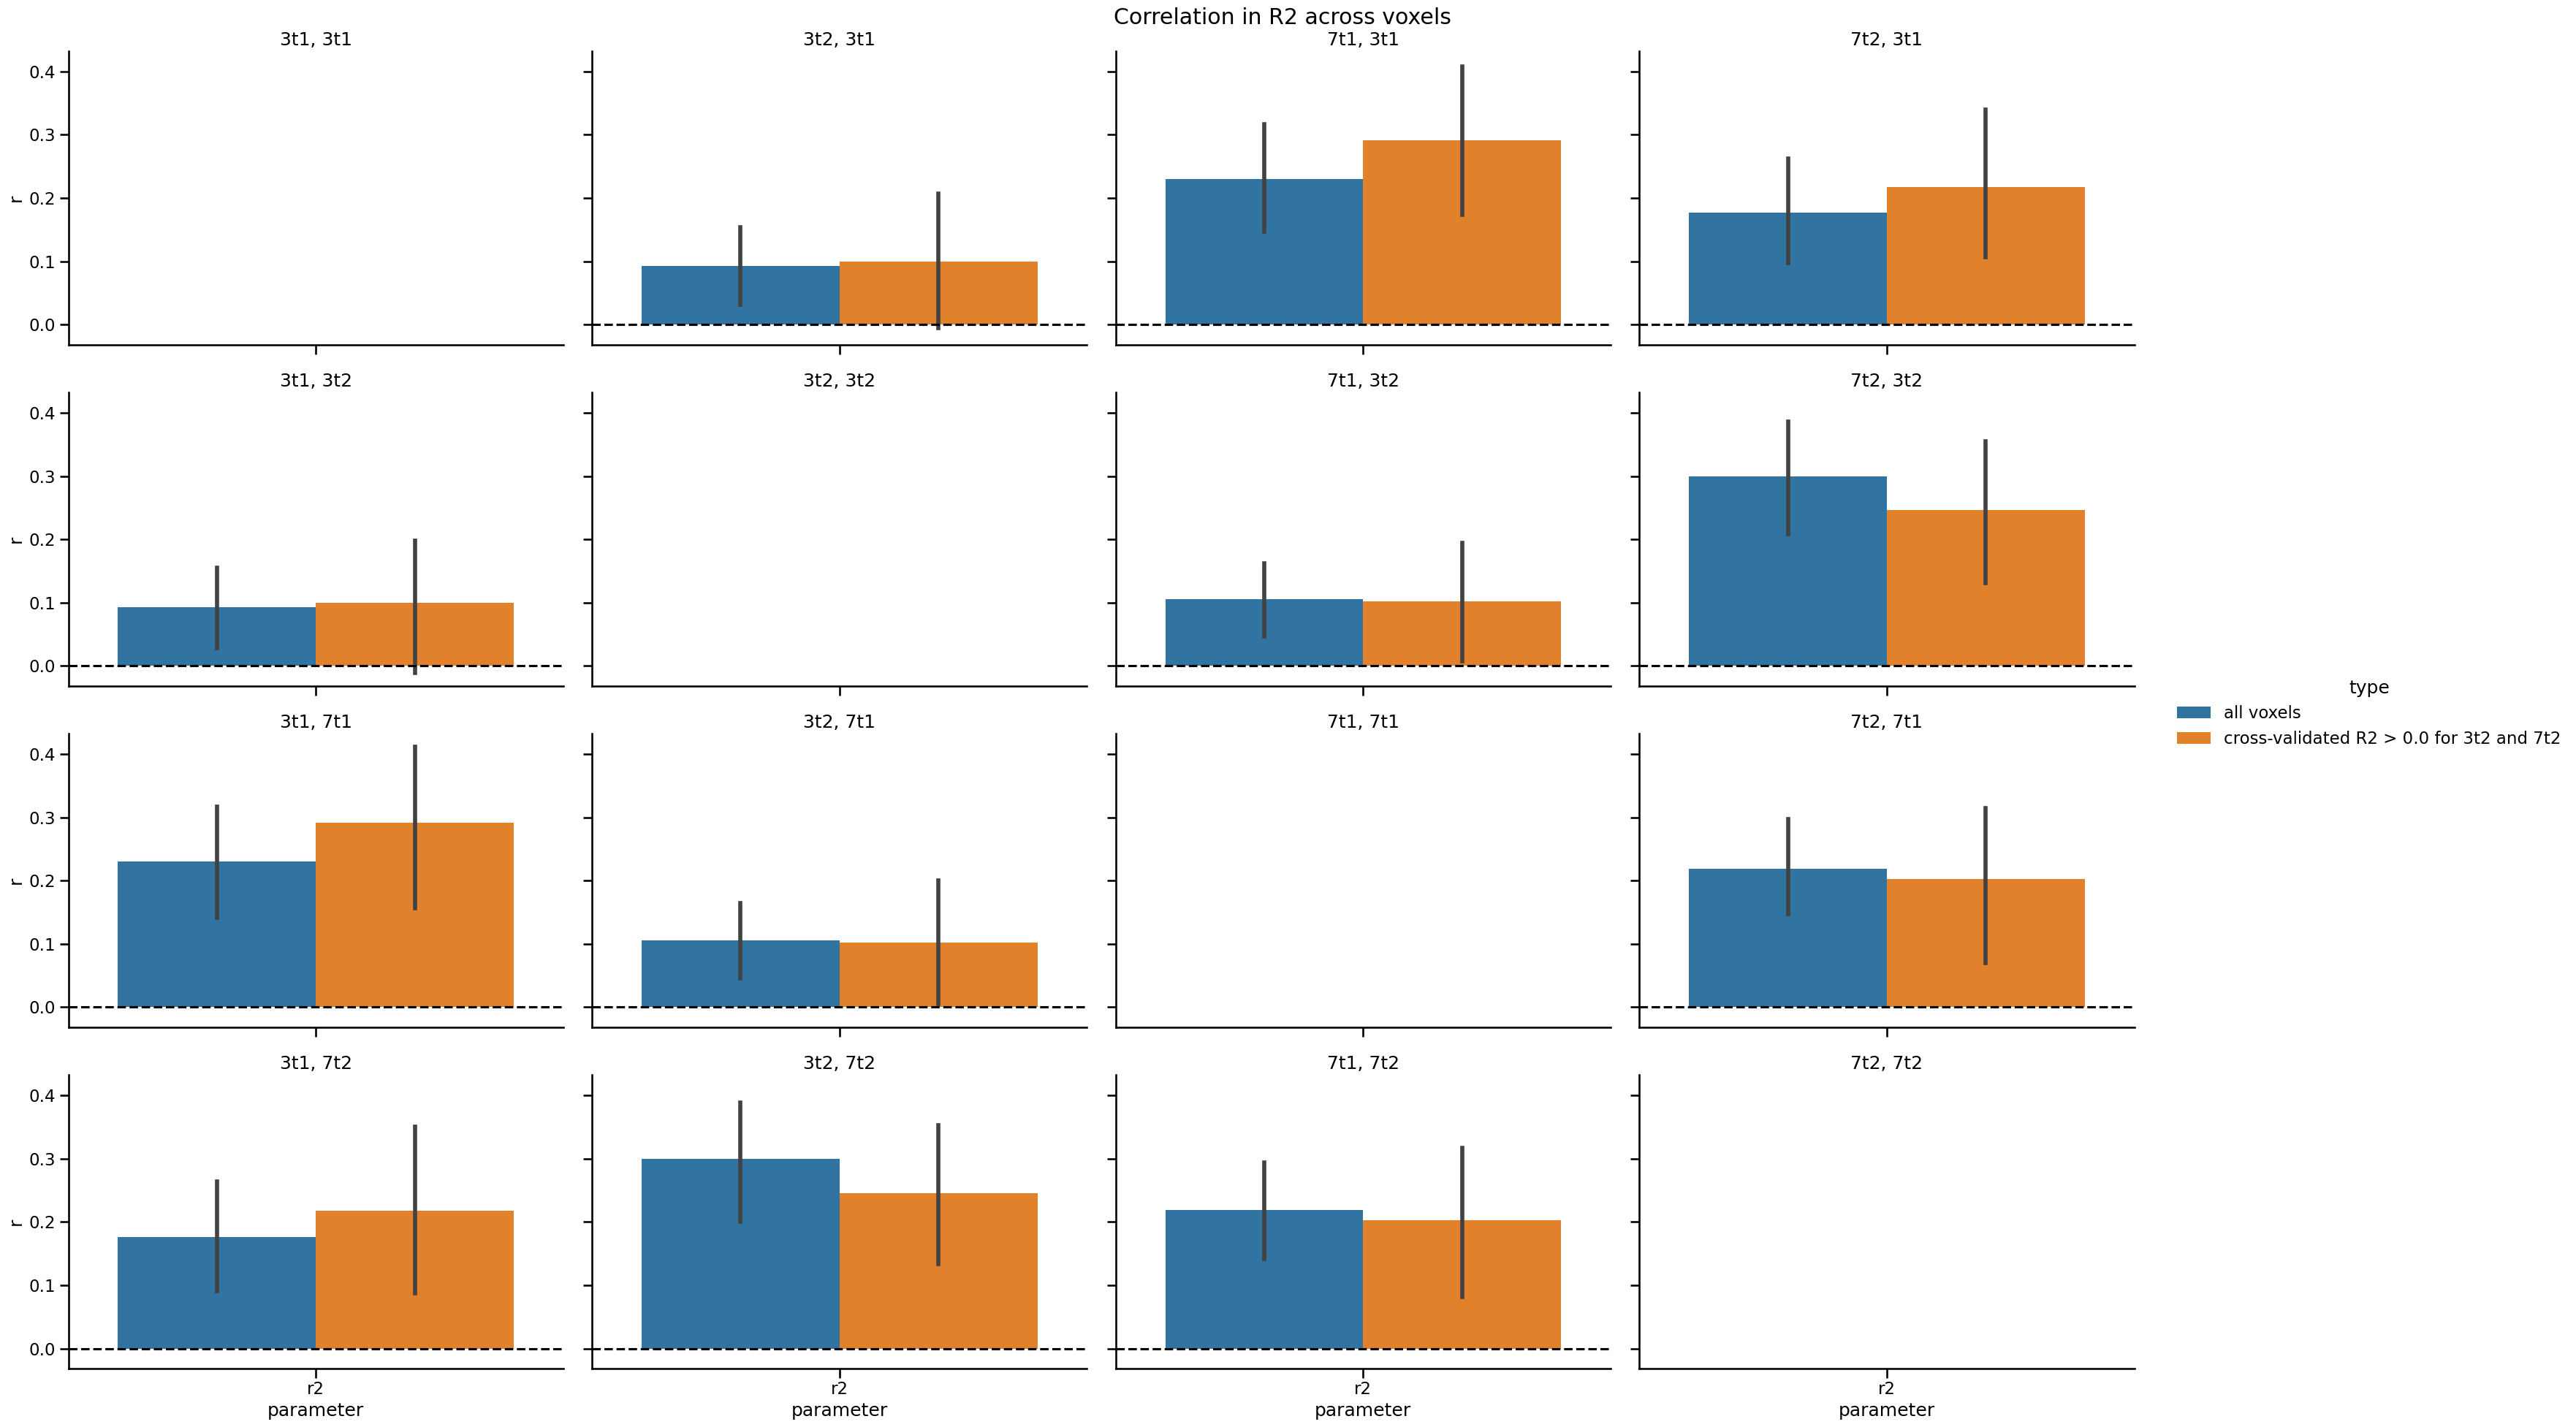

In [ ]:
g = sns.catplot(r.xs('r2', 0, 'parameter', drop_level=False).reset_index(), row='session 1', y='r', col='session 2', x='parameter', hue='type', kind='bar', dodge=True, aspect=1.5, errorbar=('ci', 95),
row_order=['3t1', '3t2', '7t1', '7t2'], col_order=['3t1', '3t2', '7t1', '7t2'])
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
g.fig.suptitle('Correlation in R2 across voxels', )
g.set_titles('{col_name}, {row_name}')
plt.subplots_adjust(top=0.95)

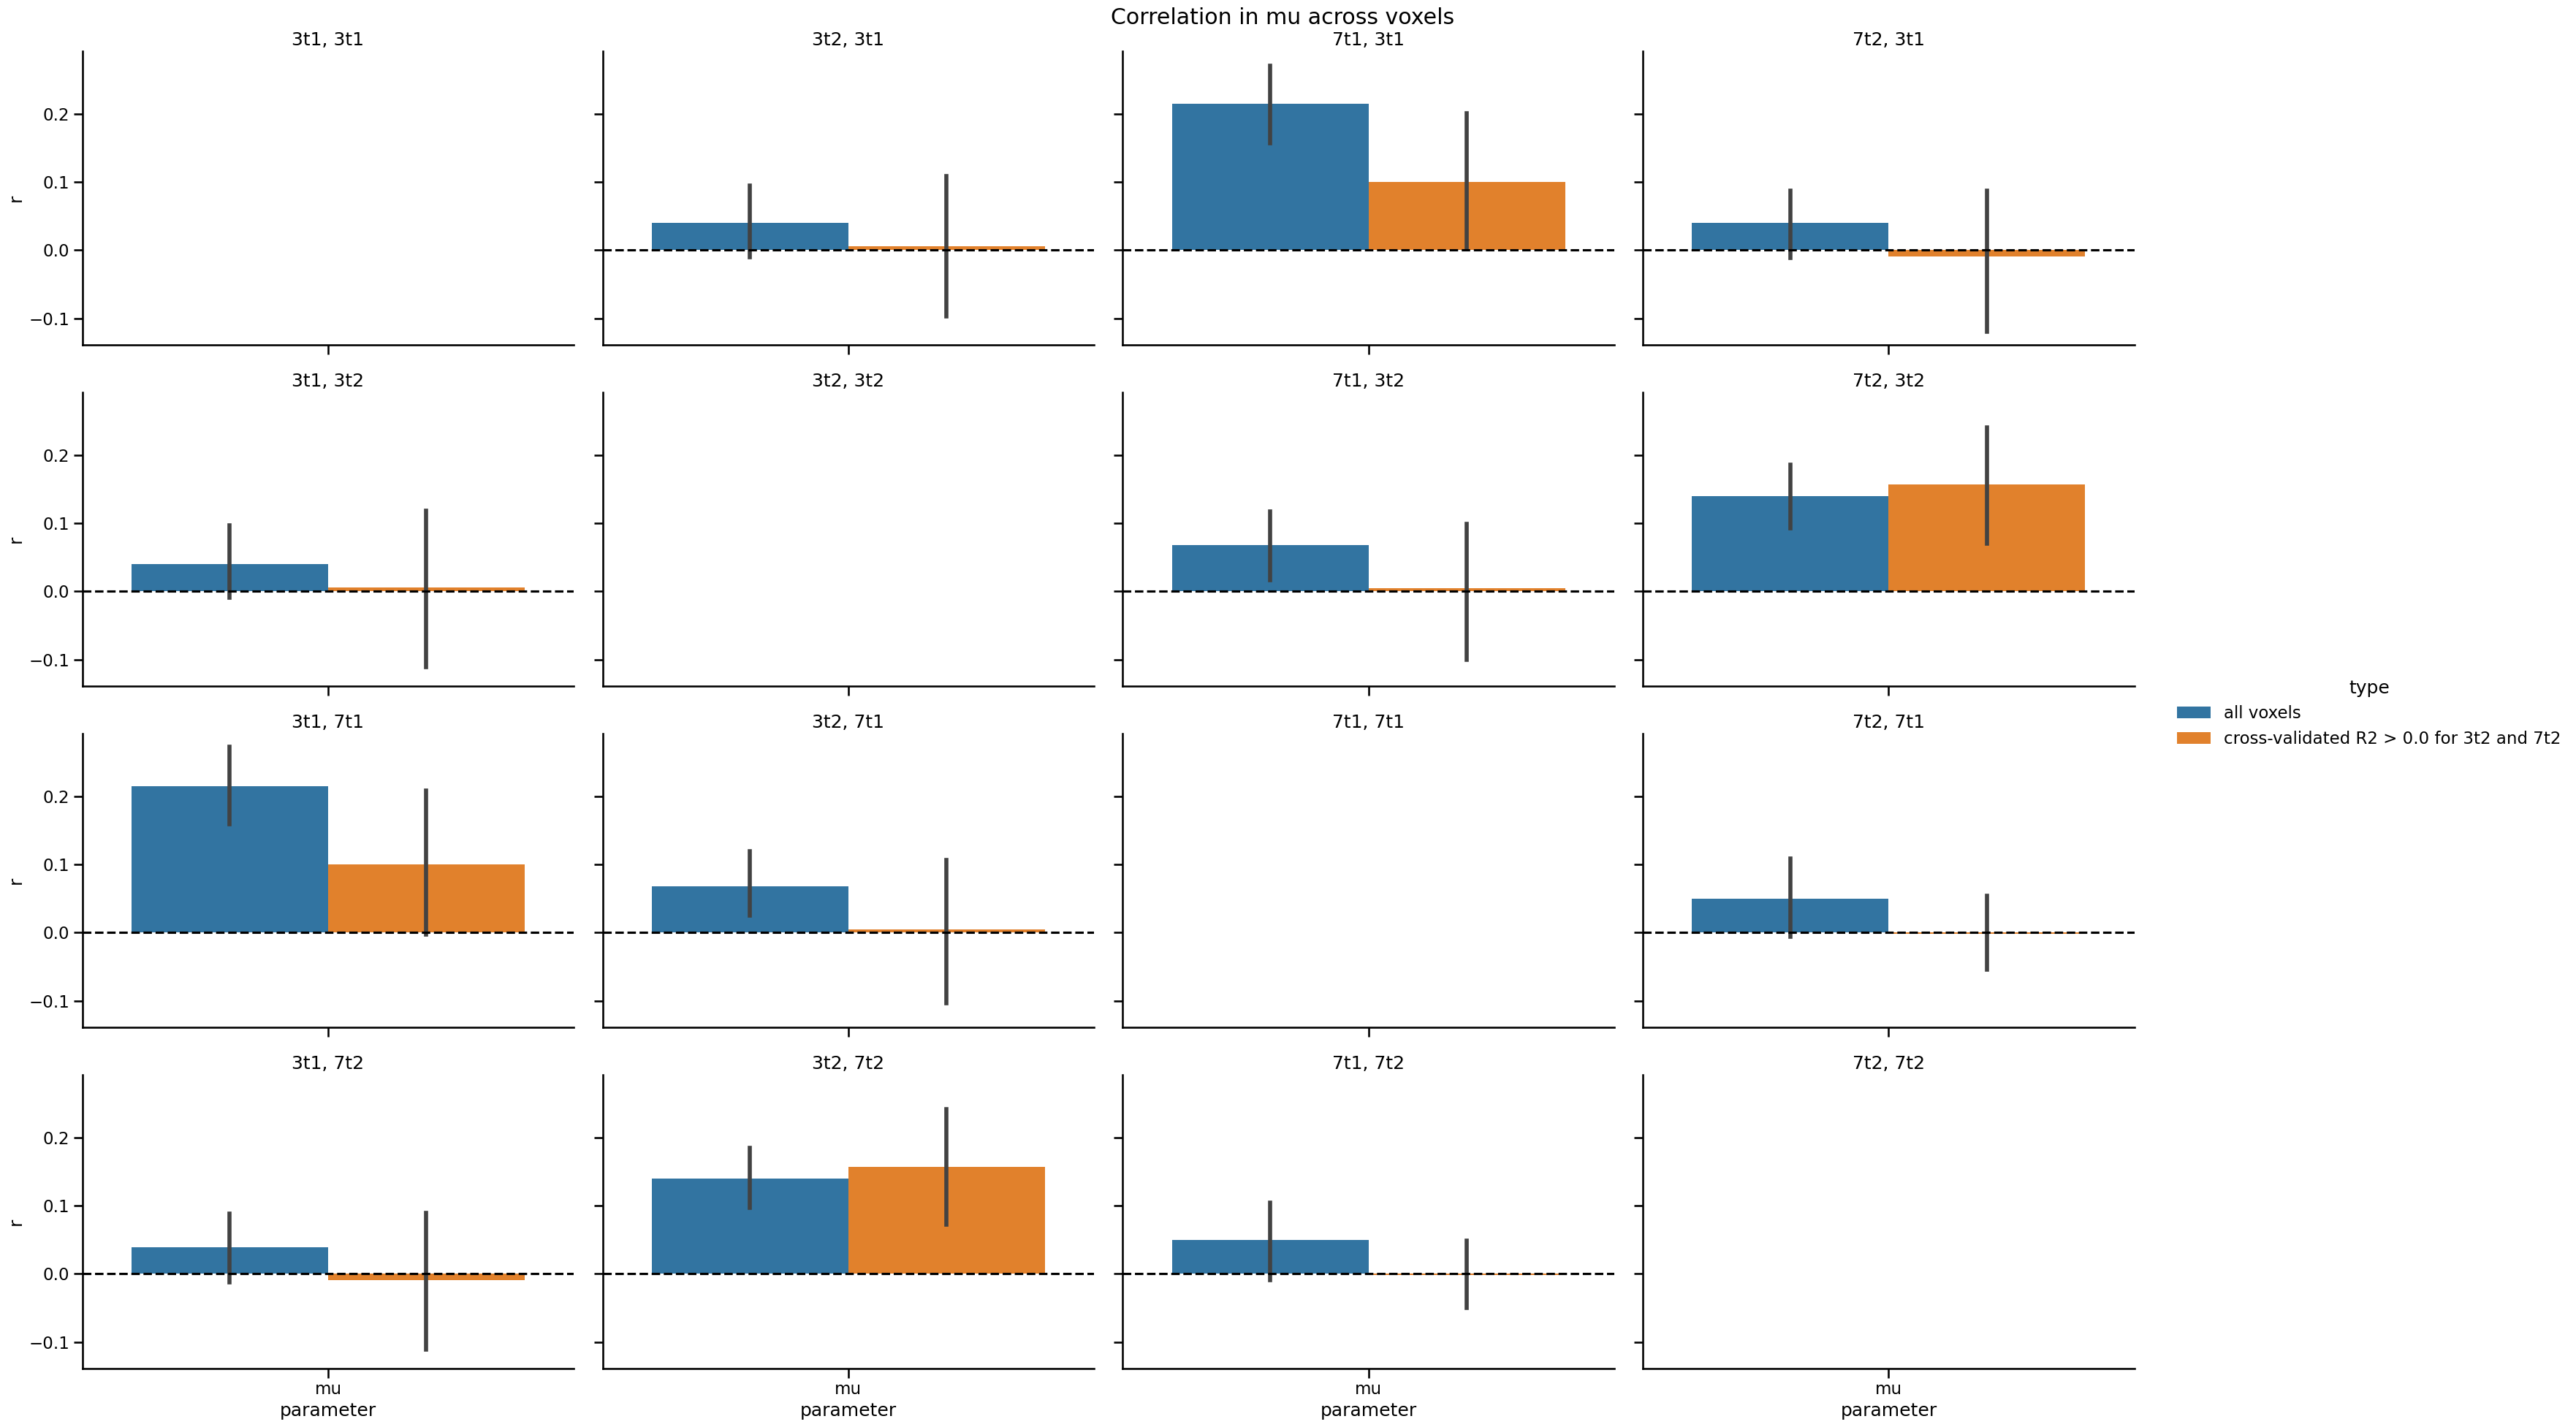

In [ ]:
g = sns.catplot(r.xs('mu', 0, 'parameter', drop_level=False).reset_index(), row='session 1', y='r', col='session 2', x='parameter', hue='type', kind='bar', dodge=True, aspect=1.5, errorbar=('ci', 95),
row_order=['3t1', '3t2', '7t1', '7t2'], col_order=['3t1', '3t2', '7t1', '7t2'])
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
g.fig.suptitle('Correlation in mu across voxels', )
g.set_titles('{col_name}, {row_name}')
plt.subplots_adjust(top=0.95)

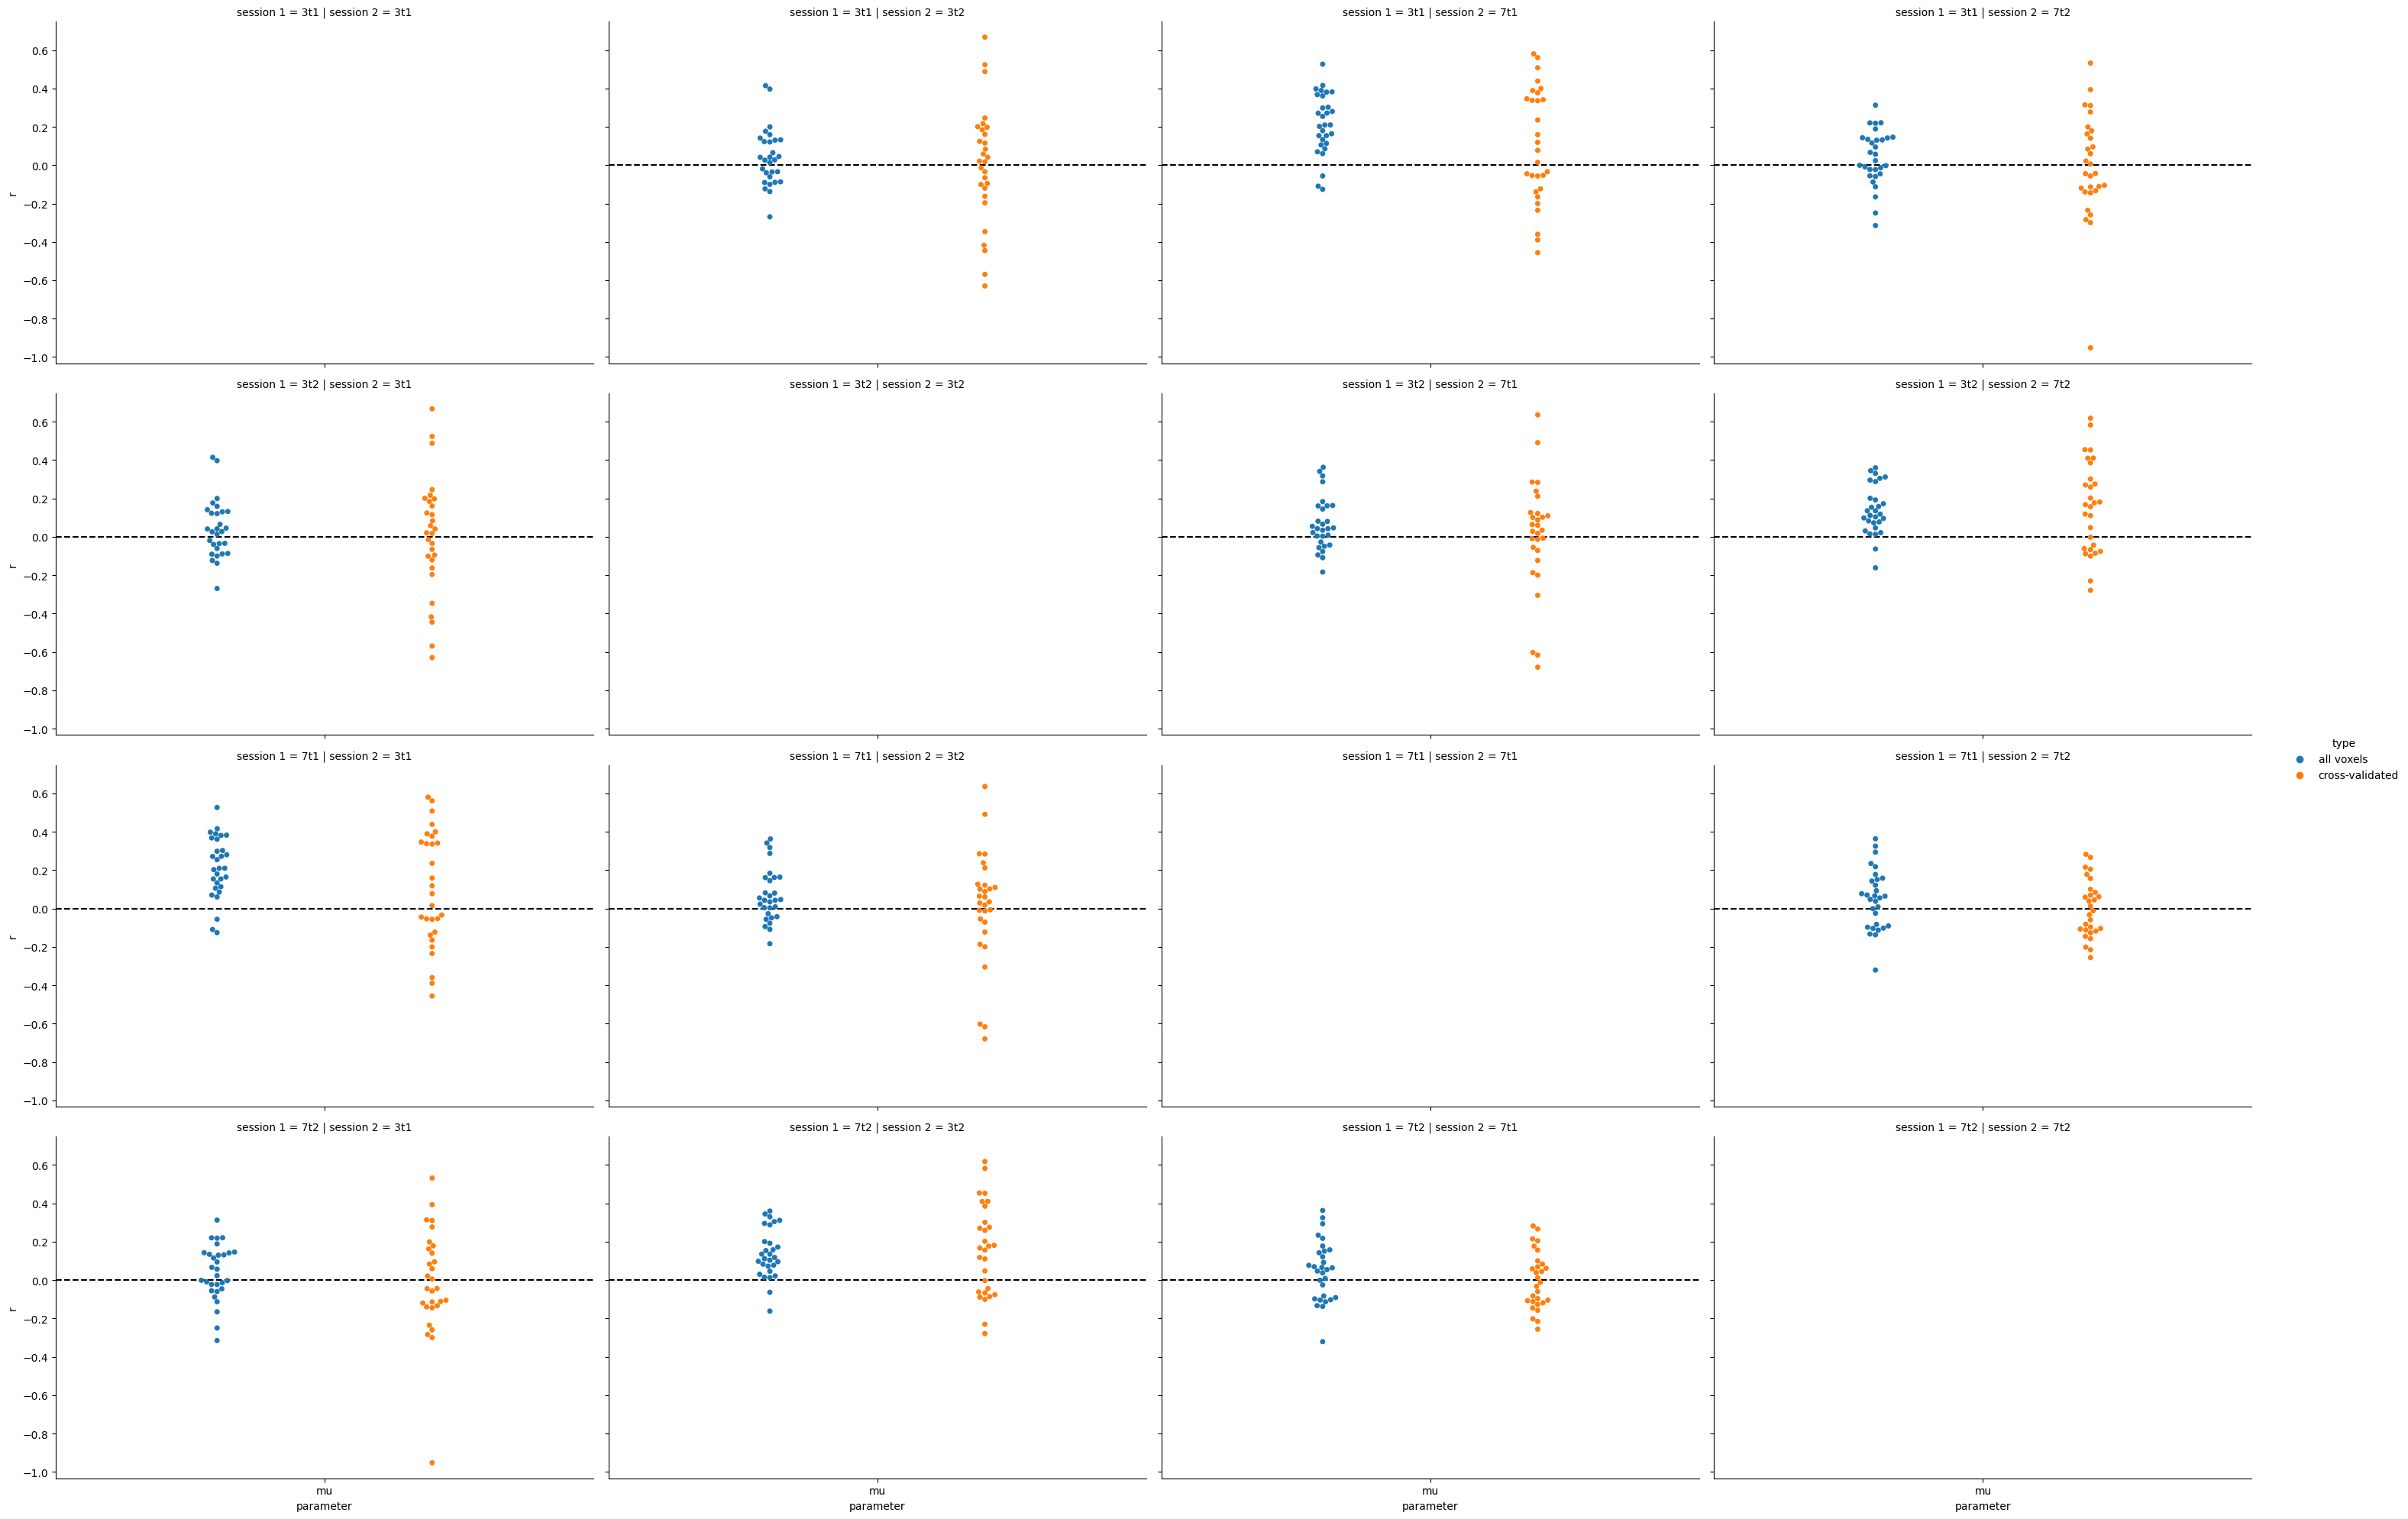

In [ ]:
g = sns.catplot(r.xs('mu', 0, 'parameter', drop_level=False).reset_index(), row='session 1', y='r', col='session 2', x='parameter', hue='type', kind='swarm', dodge=True, aspect=1.5, errorbar=('ci', 95),
row_order=['3t1', '3t2', '7t1', '7t2'], col_order=['3t1', '3t2', '7t1', '7t2'])
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

In [ ]:
pars[m].groupby('subject').apply(lambda d: d['r2'].corr()).groupby('session').mean()

session,3t1,3t2,7t1,7t2
session,,,,
3t1,1.000000,0.099944,0.291820,0.217900
3t2,0.099944,1.000000,0.102317,0.245887
7t1,0.291820,0.102317,1.000000,0.202856
7t2,0.217900,0.245887,0.202856,1.000000


In [ ]:
pars[m].groupby('subject').apply(lambda d: d['mu'].corr()).groupby('session').mean()

session,3t1,3t2,7t1,7t2
session,,,,
3t1,1.000000,0.005201,0.100264,-0.009164
3t2,0.005201,1.000000,0.004462,0.156888
7t1,0.100264,0.004462,1.000000,-0.001857
7t2,-0.009164,0.156888,-0.001857,1.000000


In [ ]:
pars.groupby('subject').apply(lambda d: d['mu'].corr()).groupby('session').mean()

session,3t1,3t2,7t1,7t2
session,,,,
3t1,1.000000,0.040309,0.214922,0.039500
3t2,0.040309,1.000000,0.067969,0.139599
7t1,0.214922,0.067969,1.000000,0.049867
7t2,0.039500,0.139599,0.049867,1.000000


In [ ]:
pars1 = sub.get_prf_parameters_volume('7t2', None, cross_validated=False, smoothed=True, denoise=True, retroicor=False, roi='npcr', include_r2=True, include_cvr2=True)
pars2 = sub.get_prf_parameters_volume('7t2', None, cross_validated=False, smoothed=True, denoise=True, retroicor=False, roi='npcr', include_r2=True, include_cvr2=True, natural_space=False)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
